# Install Required Modules

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import  precision_score, recall_score,f1_score
import numpy as np

# 1) Download the data

Get the data of Large Cap and Small Cap index from yahoo finance

In [3]:
mkt_symbs = {'Mcap':'^CRSMID',
             'Lcap':'^NSEI'}

all_mkts_close_prices = yf.download(list(mkt_symbs.values()),progress=False)['Adj Close']
all_mkts_close_prices.columns = mkt_symbs.keys()
all_mkts_close_prices = all_mkts_close_prices.fillna(method='ffill')
all_mkts_close_prices.tail()

,Mcap,Lcap
Date,,
2022-02-14,28558.750000,16842.800781
2022-02-15,29375.300781,17352.449219
2022-02-16,29289.949219,17322.199219
2022-02-17,29201.300781,17304.599609
2022-02-18,28934.349609,17276.300781


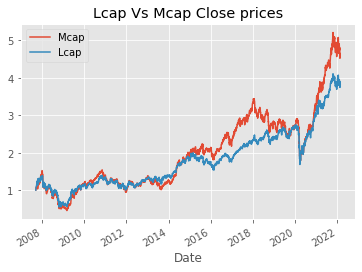

In [4]:
all_mkts_close_prices.pct_change().add(1).cumprod().plot()
plt.title('Lcap Vs Mcap Close prices')
plt.show()


# 2) Create the target

1. Get the monthly returns
2. Shift them to adjust for training
3. Resample them for every month end
4. Forward fill them get the daily target
5. Get the target label to idicate the midcap outperformance

In [5]:
return_period = 22
resample_period = 'BM'

## Actual Period Returns

In [49]:
target_returns = all_mkts_close_prices.pct_change(return_period)
target_returns.tail()

,Mcap,Lcap
Date,,
2022-02-14,-0.101687,-0.075199
2022-02-15,-0.081941,-0.049587
2022-02-16,-0.084393,-0.051137
2022-02-17,-0.088616,-0.054812
2022-02-18,-0.077979,-0.046196


## Shifted Returns

In [50]:
target_returns = target_returns.shift(-return_period).dropna()
target_returns.tail()

,Mcap,Lcap
Date,,
2022-01-12,-0.101687,-0.075199
2022-01-13,-0.081941,-0.049587
2022-01-14,-0.084393,-0.051137
2022-01-17,-0.088616,-0.054812
2022-01-18,-0.077979,-0.046196


## Resampled returns

In [51]:
resampled_period_returns = target_returns.resample(resample_period).last().dropna()
resampled_period_returns.tail()

,Mcap,Lcap
Date,,
2021-09-30,0.029524,0.015370
2021-10-29,-0.005681,-0.015279
2021-11-30,0.012566,0.012998
2021-12-31,0.017365,0.024545
2022-01-31,-0.077979,-0.046196


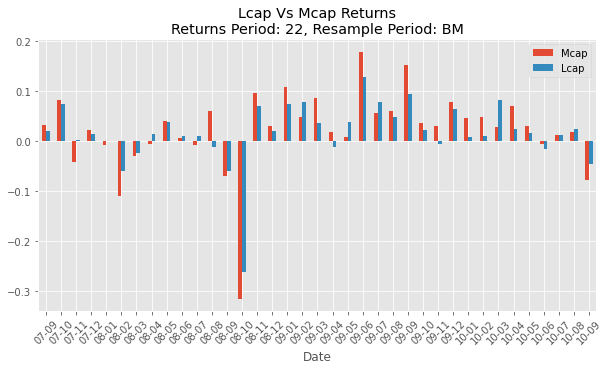

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
resampled_period_returns.loc['2019':,:].plot(kind="bar",ax=ax)
ax.set_xticklabels([x.strftime("%y-%m") for x in resampled_period_returns.index], rotation=45)
plt.title(f'Lcap Vs Mcap Returns\nReturns Period: {return_period}, Resample Period: {resample_period}')
plt.show()

## Forward filled returns

In [55]:
target_returns = pd.concat([resampled_period_returns,target_returns[[]]],axis=1).fillna(method='ffill')
target_returns = target_returns.iloc[:-1,:]
target_returns.tail()

,Mcap,Lcap
Date,,
2022-01-12,0.017365,0.024545
2022-01-13,0.017365,0.024545
2022-01-14,0.017365,0.024545
2022-01-17,0.017365,0.024545
2022-01-18,0.017365,0.024545


## Target label

In [11]:
target_returns.columns = [1,0]
target_returns['target'] = target_returns.idxmax(axis=1)
target_returns.tail()

,1,0,target
Date,,,
2022-01-13,0.017365,0.024545,0.0
2022-01-14,0.017365,0.024545,0.0
2022-01-17,0.017365,0.024545,0.0
2022-01-18,0.017365,0.024545,0.0
2022-01-31,-0.077979,-0.046196,0.0


Plot of Target

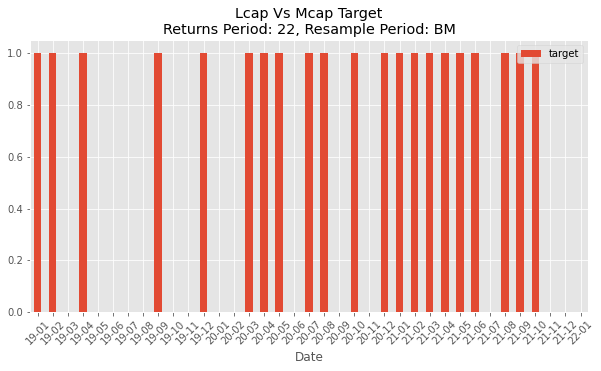

In [12]:
resampled_target = target_returns[['target']].resample(resample_period).last().loc['2019':,:].copy()
fig, ax = plt.subplots(figsize=(10,5))
resampled_target.plot(kind="bar",ax=ax)
ax.set_xticklabels([x.strftime("%y-%m") for x in resampled_target.index], rotation=45)
plt.title(f'Lcap Vs Mcap Target\nReturns Period: {return_period}, Resample Period: {resample_period}')
plt.show()

# 3) Read the indicator data

Following indicators have been created for both Large Cap and Mid Cap and combined to create a full dataset.

ADX, RSI, SMA, Actual Returns, Volatility


In [13]:
full_indc_data = pd.read_csv('full_indc_data.csv',parse_dates=True,index_col='Date')
full_indc_data.tail()

,ADX_22Lcap,ADX_66Lcap,ADX_132Lcap,RSI_14Lcap,RSI_22Lcap,RSI_66Lcap,RSI_132Lcap,SMA_14Lcap,SMA_22Lcap,SMA_66Lcap,SMA_132Lcap,Rets_RollingWeeklyLcap,Rets_RollingMonthlyLcap,Rets_RollingQtlyLcap,Vol_30Lcap,ADX_22Mcap,ADX_66Mcap,ADX_132Mcap,RSI_14Mcap,RSI_22Mcap,RSI_66Mcap,RSI_132Mcap,SMA_14Mcap,SMA_22Mcap,SMA_66Mcap,SMA_132Mcap,Rets_RollingWeeklyMcap,Rets_RollingMonthlyMcap,Rets_RollingQtlyMcap,Vol_30Mcap
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-11,16.363551,8.902435,6.744567,46.603976,47.681062,51.082428,53.582373,0.019983,0.779298,0.362391,0.248870,-0.008081,-0.037717,-0.037103,0.010780,18.888636,9.939558,6.667117,41.543565,44.150308,50.009767,53.327086,0.584837,1.384978,1.363222,0.699361,-0.023394,-0.053216,-0.076335,0.013019
2022-02-14,16.802694,8.959037,6.731127,37.325283,41.070574,48.152461,51.874352,1.614321,2.256646,1.973638,1.928181,-0.021541,-0.075199,-0.065182,0.012049,19.806747,10.123431,6.716016,32.584802,37.586369,47.080231,51.552268,2.346722,3.031650,3.157019,2.564450,-0.052125,-0.101687,-0.108777,0.014562
2022-02-15,16.785697,8.960324,6.703587,48.006038,48.269070,50.892580,53.311124,0.037642,0.527788,0.351213,0.355420,0.004963,-0.049587,-0.029158,0.013000,20.498068,10.283821,6.759095,41.982919,43.702531,49.188344,52.659647,1.024577,1.552821,1.806364,1.291569,-0.018102,-0.081941,-0.075730,0.015424
2022-02-16,16.598073,8.939430,6.670403,47.488742,47.905197,50.730995,53.216104,0.184789,0.510267,0.424653,0.493306,-0.008108,-0.051137,-0.043118,0.012845,20.978360,10.421579,6.796519,41.334275,43.238548,48.981251,52.533177,1.188631,1.545630,1.941335,1.489782,-0.031964,-0.084393,-0.082563,0.015406
2022-02-17,16.444276,8.922448,6.638525,47.170267,47.686091,50.636019,53.160557,0.293681,0.429198,0.451226,0.587203,-0.017111,-0.054812,-0.044444,0.012765,21.457288,10.560180,6.834562,40.632097,42.744759,48.764731,52.401468,1.357204,1.592057,2.167136,1.774998,-0.037641,-0.088616,-0.088266,0.015396


In [14]:
full_indc_data.columns

Index(['ADX_22Lcap', 'ADX_66Lcap', 'ADX_132Lcap', 'RSI_14Lcap', 'RSI_22Lcap',
       'RSI_66Lcap', 'RSI_132Lcap', 'SMA_14Lcap', 'SMA_22Lcap', 'SMA_66Lcap',
       'SMA_132Lcap', 'Rets_RollingWeeklyLcap', 'Rets_RollingMonthlyLcap',
       'Rets_RollingQtlyLcap', 'Vol_30Lcap', 'ADX_22Mcap', 'ADX_66Mcap',
       'ADX_132Mcap', 'RSI_14Mcap', 'RSI_22Mcap', 'RSI_66Mcap', 'RSI_132Mcap',
       'SMA_14Mcap', 'SMA_22Mcap', 'SMA_66Mcap', 'SMA_132Mcap',
       'Rets_RollingWeeklyMcap', 'Rets_RollingMonthlyMcap',
       'Rets_RollingQtlyMcap', 'Vol_30Mcap'],
      dtype='object')

In [15]:
full_indc_data.shape

(3267, 30)

# 4) Train, Validation and Test Split

In [16]:
test_size = 0.15
val_size = 0.15

## Test Data

In [17]:
#Split the data into train and test
text_start_ix = int(full_indc_data.shape[0]*test_size)
x_test = full_indc_data.iloc[-text_start_ix:].copy()
y_test = target_returns.loc[x_test.index.min():,'target'].copy() 
print(f'Test Data size: {x_test.shape}')

Test Data size: (490, 30)


## Full Train Data

In [18]:
full_x_train = full_indc_data.iloc[:-text_start_ix].copy()
full_y_train = target_returns.loc[:full_x_train.index.max(),'target'].copy()

full_x_train = full_x_train.loc[full_x_train.index.isin(full_y_train.index),:]
full_y_train = full_y_train.loc[full_y_train.index.isin(full_x_train.index)]
print(f'Full train Data size: {full_x_train.shape}')

Full train Data size: (2777, 30)


## Adjust the full train for data wait period

In [19]:
full_x_train = full_x_train.iloc[:-return_period]
full_y_train = full_y_train.iloc[:-return_period]
print(f'Full train Data size: {full_x_train.shape}')

Full train Data size: (2755, 30)


## Validation data

In [20]:
val_start_ix = int(full_x_train.shape[0]*val_size)
x_val = full_x_train.iloc[-val_start_ix:,:].copy()
y_val = full_y_train.iloc[-val_start_ix:].copy()
print(f'Validation Data size: {x_val.shape}')

Validation Data size: (413, 30)


## Train Data

In [21]:
x_train = full_x_train.iloc[:-val_start_ix,:].copy()
y_train = full_y_train.iloc[:-val_start_ix].copy()
print(f'Train Data size: {x_train.shape}')

Train Data size: (2342, 30)


# 5) Scale the variables

In [22]:
std_scalar_train = StandardScaler()
x_train = pd.DataFrame(std_scalar_train.fit_transform(x_train),index=x_train.index,columns=x_train.columns)
x_val = pd.DataFrame(std_scalar_train.transform(x_val),index=x_val.index,columns=x_val.columns)
x_test = pd.DataFrame(std_scalar_train.transform(x_test),index=x_test.index,columns=x_test.columns)
full_x_train = pd.DataFrame(std_scalar_train.transform(full_x_train),index=full_x_train.index,columns=full_x_train.columns)

# 6) Basic KNN Model

## Model Building

In [23]:
#initiating the model
knn = KNeighborsClassifier()
#fitting the model on train
knn.fit(x_train,y_train)

KNeighborsClassifier()

In [24]:
#train and val preds
train_preds_knn = pd.Series(knn.predict(x_train),index=x_train.index)
val_preds_knn = pd.Series(knn.predict(x_val),index=x_val.index)

## Metrics Function

In [25]:
#Function to get metrics
def get_metrics(actuals,preds,expname):
    prec = precision_score(actuals,preds)
    recal = recall_score(actuals,preds)
    f1 = f1_score(actuals,preds)
    metrics = pd.DataFrame([[prec,recal,f1]],index=[expname])
    metrics.columns = ['Precision','Recall','F1Score']
    return metrics

## Results

In [26]:
get_metrics(y_train,train_preds_knn,'train_default_parms')

,Precision,Recall,F1Score
train_default_parms,0.982585,0.985887,0.984233


In [27]:
get_metrics(y_val,val_preds_knn,'val_default_parms')

,Precision,Recall,F1Score
val_default_parms,0.377622,0.339623,0.357616


# 7) Search for best parameters

## Parameter search

In [28]:
#validated results
n_neighbors_list = np.arange(1,20,2)
all_metrics = pd.DataFrame()
for n in n_neighbors_list:
    #initiating the model
    knn = KNeighborsClassifier(n_neighbors=n,weights='distance')
    #fitting the model on train
    knn.fit(x_train,y_train)
    
    #train and val preds
    train_preds_knn = pd.Series(knn.predict(x_train),index=x_train.index)
    val_preds_knn = pd.Series(knn.predict(x_val),index=x_val.index)
    
    #metrics
    all_metrics = pd.concat([all_metrics,get_metrics(y_train,train_preds_knn,f'train_{n}_nbrs')])
    all_metrics = pd.concat([all_metrics,get_metrics(y_val,val_preds_knn,f'val_{n}_nbrs')])
all_metrics.reset_index(inplace=True)

## Validation results

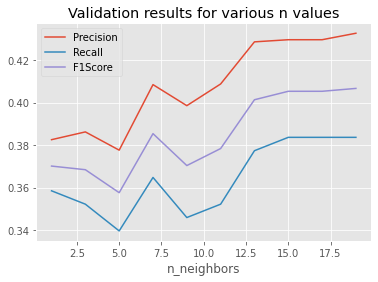

In [29]:
val_results = all_metrics.loc[all_metrics['index'].str.contains('val'),:].copy()
val_results.index = n_neighbors_list
val_results.index.name = 'n_neighbors'
val_results[['Precision','Recall','F1Score']].plot()
plt.title('Validation results for various n values')
plt.show()

In [30]:
val_results

,index,Precision,Recall,F1Score
n_neighbors,,,,
1,val_1_nbrs,0.382550,0.358491,0.370130
3,val_3_nbrs,0.386207,0.352201,0.368421
5,val_5_nbrs,0.377622,0.339623,0.357616
7,val_7_nbrs,0.408451,0.364780,0.385382
9,val_9_nbrs,0.398551,0.345912,0.370370
11,val_11_nbrs,0.408759,0.352201,0.378378
13,val_13_nbrs,0.428571,0.377358,0.401338
15,val_15_nbrs,0.429577,0.383648,0.405316
17,val_17_nbrs,0.429577,0.383648,0.405316


# 8) Building model with best params

Using the best parameters build the model on full train and get the test predictions

In [31]:
#initiating the model
knn = KNeighborsClassifier(n_neighbors=13,weights='distance')
#fitting the model on train
knn.fit(full_x_train,full_y_train)

#train and val preds
train_preds_knn = pd.Series(knn.predict(full_x_train),index=full_x_train.index)
test_preds_knn = pd.Series(knn.predict(x_test),index=x_test.index)

In [32]:
get_metrics(full_y_train,train_preds_knn,'train_best_parms')

,Precision,Recall,F1Score
train_best_parms,1.0,1.0,1.0


In [33]:
get_metrics(y_test.loc[y_test.index.isin(test_preds_knn.index)],
            test_preds_knn.loc[test_preds_knn.index.isin(y_test.index)],'test_best_parms')

,Precision,Recall,F1Score
test_best_parms,0.729798,0.889231,0.801664


# 9) Plot of Actuals and Preds from Test

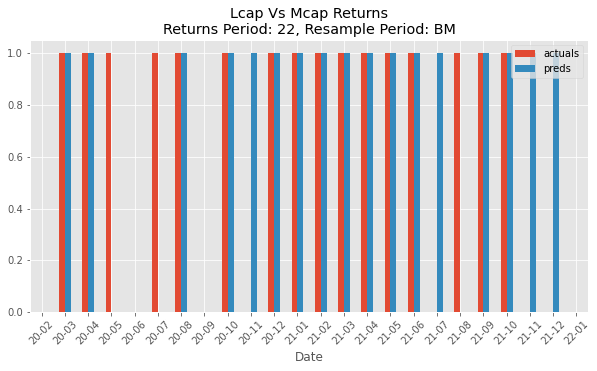

In [34]:
plot = pd.concat([target_returns['target'],test_preds_knn.resample(resample_period).last()],axis=1)
plot = plot.dropna()
plot.columns = ['actuals','preds']
fig, ax = plt.subplots(figsize=(10,5))
plot.plot(kind="bar",ax=ax)
ax.set_xticklabels([x.strftime("%y-%m") for x in plot.index], rotation=45)
plt.title(f'Lcap Vs Mcap Returns\nReturns Period: {return_period}, Resample Period: {resample_period}')
plt.show()

# 10) Compare the returns

In [35]:
returns_summary = pd.concat([target_returns[[0,1]],test_preds_knn.resample(resample_period).last()],axis=1)
returns_summary = returns_summary.dropna()
returns_summary.columns = ['Lcap','Mcap','Preds']
returns_summary['Model'] = returns_summary['Lcap']
returns_summary.loc[returns_summary['Preds']==1,'Model'] = returns_summary.loc[returns_summary['Preds']==1,'Mcap']
returns_summary[['Lcap','Mcap','Model']].describe()

,Lcap,Mcap,Model
count,24.000000,24.000000,24.000000
mean,0.024567,0.035202,0.035769
std,0.073447,0.091137,0.079024
min,-0.263169,-0.316650,-0.263169
25%,0.010032,0.017846,0.022006
50%,0.023942,0.041436,0.036166
75%,0.071288,0.072106,0.064629
max,0.128109,0.179343,0.179343
